# Analysis of free fall data

This notebook contains the script to analyse data collected during the freefall experiment. We begin, as usual, importing the needed modules.

In [42]:
import pandas as pd
import numpy as np

Then, we read data from a CSV file using pandas' ``read_csv()`` method, to which the filename is passed as an argument. Data are arranged as a matrix: each column is a list of data: the first column contains the height, the second the time. To convert these data into lists we need to transpose the matrix (``.T``), access its values ignoring the headers (``.values``) and transform them into a list (``.tolist()``).

In [38]:
f = pd.read_csv('../phyphox/freefall.csv')
data = f.T.values.tolist()
x = data[0]
y = data[1]

At this point we want to make a plot of y vs x. This is done using the ``matplotlib.pyplot`` package.

========== simple linear model


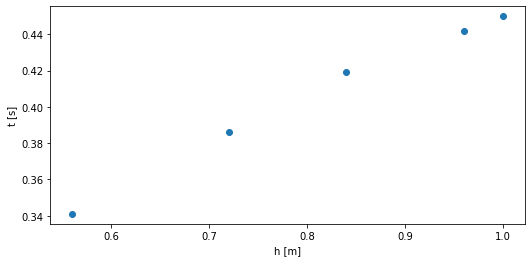

In [39]:
import matplotlib.pyplot as plt

print('========== simple linear model')
fig = plt.figure(figsize=(8.5,4))
plt.plot(x, y, 'o')
plt.xlabel('h [m]')
plt.ylabel('t [s]')
plt.show()

## A simple, linear model

Data seem to distribute along a straight line. The slope of the line can be obtained computing the average of the ratios $\frac{\Delta y_{i,j}}{\Delta x_{i,j}}$, where $\Delta x_{i,j} = x_j-x_i$ and similarly for $\Delta y_{i,j}$. We find all the possible pairs $i,\,j$, then we find their average.

The list of all the possible $i,\,j$ pairs can be found all the combinations of two elements out of $N$ with no repetitions. This is done using the ``combinations`` subpackage from ``itertools``: its ``comb`` method returns a tuple containing all the possible combinations. The first argument of the method is a list of elements (in our case the list is composed by integers from 0 to $N$, where $N$ is the number of elements. Since $N$ is equal to the size (``len()``) of x, we can build the list as numpy's ``np.arange(len(y))``.

Looping on all the possible combinations we compute the ratio above and their average. The uncertainty on the average is computed as $\sigma^2 = \langle x^2\rangle - \langle x\rangle^2$.

In [40]:
from itertools import combinations as comb

def averageSlope(x, y):
    ijpairs = list(comb(np.arange(len(y)), 2))
    m = 0
    m2 = 0
    for ij in ijpairs:
        i = ij[0]
        j = ij[1]
        s = (y[i]-y[j])/(x[i]-x[j])
        m += s
        m2 += s*s
    N = len(ijpairs)
    m /= N    
    sigma = np.sqrt(m2/N-m*m)
    return m, sigma

m, sigma = averageSlope(x, y)

To write it properly we define a dedicated function that evaluate the number of significant figures in the unceratinty and returns both the uncertainty and the average using the appropriate number of digits. To show how this is accomplished, we print the values as they are compute and, in parenthesis, the rounded one.

In [41]:
def truncatedMeasurement(m, sigma):
    e = np.floor(np.log(np.abs(sigma))/np.log(10))
    mprime = np.round(m/10**e,0)*10**e
    return mprime

alpha = truncatedMeasurement(m, sigma)
print('Slope = {} +- {} ({})'.format(m, sigma, alpha))

Slope = 0.23823701298701305 +- 0.03293846902060876 (0.24)


We do the same to compute the intercept of the line interpolating data. The intercept is found computing the average intercept as

$\beta=\frac{1}{N}\sum_{i=1}^N{y_i - \alpha x_i}$

In [35]:
def averageIntercept(x, y, slope):
    vbeta = []
    for i in range(len(x)):
        vbeta.append(y[i]-slope*x[i])
    beta = np.mean(vbeta)
    dbeta = np.std(vbeta)
    return beta, dbeta

beta, dbeta = averageIntercept(x, y, alpha)
betat = truncatedMeasurement(beta, dbeta)
print('Beta = {} +- {} ({})'.format(beta, dbeta, betat))

Beta = 0.21176000000000003 +- 0.0035674080226405294 (0.212)


Now we redo the plot superimposing the line $y=\alpha x + \beta$ and we decorate it with some information to the reader. Moreover, we impose the limits for both $x$ and $y$ axis, such that the origin is visible.

Together with the linear model, we show an alternative model such that $t\propto \sqrt{h}$, as predicted for an object falling with constant acceleration. While for the linear model $t(0) \ne 0$, for the alternative one, $t(0)=0$. It then appears to be more reasonable.

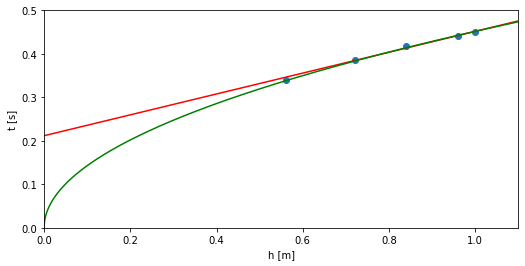

In [36]:
    fig = plt.figure(figsize=(8.5,4))
    xrange = np.arange(0., 1.1, .001)
    plt.plot(x, y, 'o')
    model = alpha*xrange + beta
    plt.plot(xrange, model, '-r')
    plt.xlabel('h [m]')
    plt.ylabel('t [s]')
    plt.xlim(0., 1.1)
    plt.ylim(0., 0.5)
    plt.plot(xrange, np.sqrt(2*xrange/9.8), '-g')
    plt.show()

## A better model

To find the parameters of the constant acceleration model, it is a good idea to *linearise* the model, i.e. to plot a function of the data such that it appears as a straight line: in this case it is enough to plot $t^2$ as a function of $h$ instead of $t$:

========== linearised model


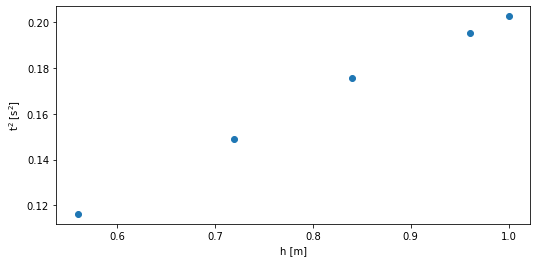

Slope = 0.1927297272727273 +- 0.01709738848406902 (0.19)
Beta = 0.01270040000000001 +- 0.0019465144849191295 (0.013000000000000001)


In [14]:
print('========== linearised model')
fig = plt.figure(figsize=(8.5,4))
t2 = [t*t for t in y]
plt.plot(x, t2, 'o')
plt.xlabel('h [m]')
plt.ylabel('t$^2$ [s$^2$]')
plt.show()
m, sigma = averageSlope(x, t2)
alpha = truncatedMeasurement(m, sigma)
print('Slope = {} +- {} ({})'.format(m, sigma, alpha))
beta, dbeta = averageIntercept(x, t2, alpha)
betat = truncatedMeasurement(beta, dbeta)
print('Beta = {} +- {} ({})'.format(beta, dbeta, betat))

We found the slope and the intercept of $t^2$ vs $h$ as above. Now we plot the model, too.

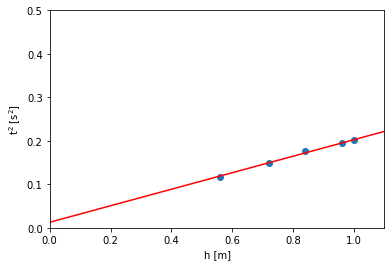

In [15]:
    model = alpha * xrange + beta
    plt.plot(x, t2, 'o')
    plt.xlim(0., 1.1)
    plt.ylim(0., 0.5)
    plt.plot(xrange, model, '-r')
    plt.xlabel('h [m]')
    plt.ylabel('t$^2$ [s$^2$]')
    plt.show()

## Taking into account the finite speed of the sound

Indeed, the model seems not to be correct yet. In fact, even in this case, the intercept is not compatible with zero. The reason being that we must correct for the time needed to the sound to reach the phone to trigger its stop.

In addition to a correction due to the sound travel time, we also add a constant offset that takes into account the fact that the phone takes some time to perform the operations leading to start and stop the time. That time is reasonably constant.

========== corrected model


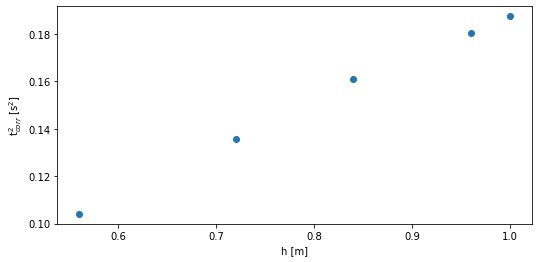

Slope = 0.18662021657754013 +- 0.015789870789510684 (0.19)
Beta = -0.0012993093425605674 +- 0.0015011638302182668 (-0.001)


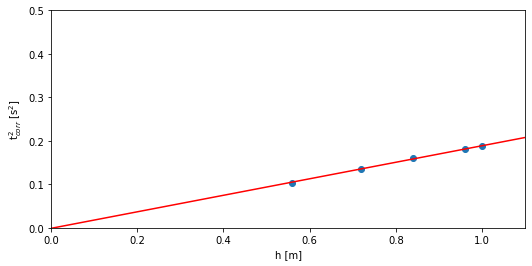

In [26]:
print('========== corrected model')
fig = plt.figure(figsize=(8.5,4))
t2c = []
for i in range(len(x)):
    tc = y[i]+x[i]/340-0.02
    t2c.append(tc*tc)
plt.plot(x, t2c, 'o')
plt.xlabel('h [m]')
plt.ylabel('t$^2_{corr}$ [s$^2$]')
plt.show()
m, sigma = averageSlope(x, t2c)
alpha = truncatedMeasurement(m, sigma)
print('Slope = {} +- {} ({})'.format(m, sigma, alpha))
beta, dbeta = averageIntercept(x, t2c, alpha)
betat = truncatedMeasurement(beta, dbeta)
print('Beta = {} +- {} ({})'.format(beta, dbeta, betat))

fig = plt.figure(figsize=(8.5,4))
model = alpha * xrange + beta
plt.plot(x, t2c, 'o')
plt.xlim(0., 1.1)
plt.ylim(0., 0.5)
plt.plot(xrange, model, '-r')
plt.xlabel('h [m]')
plt.ylabel('t$^2_{corr}$ [s$^2$]')
plt.show()